## The Context
[Afterpay's](https://www.afterpay.com/index) business model is pretty simple. Afterpay allows customers to pay for products in 4 separate payments every two weeks and charges stores a margin for this. At a high level, *Afterpays* revenues are a function of how many customers they have and how often they use Afterpay. 

Sometimes things don't go to plan, and customers default on their payments, and this is where things get a bit more complex. 

It's also an area that I believe that *Afterpay* has been somewhat nebulous. Even if *Afterpay* doesn't tell us directly, it might be possible to infer and gain more clarity about what we have not been directly told.

However, there are many positive aspects to *Afterpay's* business model compared to credit cards. 


:::{.callout-important}

Obviously, I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.

:::

## Why create synthetic data?

Before we try and infer based on what *Afterpay* has told us, a significant first step might be to build a model to generate synthetic data. Let's simulate *Afterpay*, then generate some artificial outcomes. We can try and infer "hidden" parameters from these outcomes in our model. Because this is a simulation, we can see how well we can infer based on what we observe.

While this seems like a contrived toy example, it's a compelling first step. If we can't effectively infer from our synthetic data, we can't hope to infer anything about reality.

## The model

Let's keep things as simple as possible initially. We can always create a more sophisticated but wrong model later.

Ok. So let's assume that *Afterpay* does some number of transactions per year. These transactions have an average value; let's take 100 AUD. For each transaction, they are paid some margin by the merchant. Let's assume 4%.

For some of these transactions, the customer defaults 1% of the time. This means that they make no repayments at all against the 100 AUD.  

Glossing over the *Afterpay* fee structure, let's assume they pay *Afterpay* 25 AUD in fees, and Afterpay is liable for the transaction value (100 AUD).

Let's now model this out in code.

In [7]:
def compute_revenue(average_transaction_value = 100, margin_percent = 0.04, number_of_transactions = 10**6, default_rate = 0.01, average_default_fee  = 25):
    
    gross_transaction_value = number_of_transactions * average_transaction_value
    
    default_losses = default_rate * number_of_transactions * average_transaction_value
    
    default_fee_rev = default_rate * number_of_transactions * average_default_fee 
    
    gross_afterpay_rev = margin_percent * gross_transaction_value +  default_fee_rev - default_losses
    
    return(gross_afterpay_rev, default_fee_rev, gross_transaction_value, default_losses)


compute_revenue()

(3250000.0, 250000.0, 100000000, 1000000.0)

In [10]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

In [30]:
with pm.Model() as model:
    gross_afterpay_rev = 3_250_000.0
    default_fee_rev =  250_000.0
    gross_transaction_value = 100_000_000.0
    default_fee = 25
    margin_percent = 0.04
    
    
    default_rate =  pm.Beta('loss_rate', alpha=1, beta=4) 
    
    average_default_fee = pm.Uniform('average_default_fee',lower = 10, upper = 68)
    
    number_of_transactions = pm.Exponential('number_of_transactions', lam= 1.0/10**6)
    
    average_transaction_value = pm.Exponential('average_transaction_value', lam= 1.0/100)
    
    gross_transaction_value =  pm.Normal('gross_transaction_value', mu = number_of_transactions * average_transaction_value, sigma = 10_000_000 , observed = [100_000_000])
    
    default_losses = pm.Normal('default_losses', mu = default_rate * gross_transaction_value, sigma = 100_000, observed =  [1_000_000])
    
    default_fee_rev = pm.Normal('default_fee_rev', mu = default_rate * number_of_transactions * average_default_fee, sigma = 25_000, observed =  [250_000])
    
    gross_afterpay_rev = pm.Normal('gross_afterpay_rev', mu = margin_percent * gross_transaction_value +  default_fee_rev - default_losses, sigma = 325_000, observed = [3_250_000])
    
    

In [31]:
with model:
    trace = pm.sample(draws=10_000,tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [average_transaction_value, number_of_transactions, average_default_fee, loss_rate]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [00:41<00:00, 716.68draws/s]
The number of effective samples is smaller than 25% for some parameters.


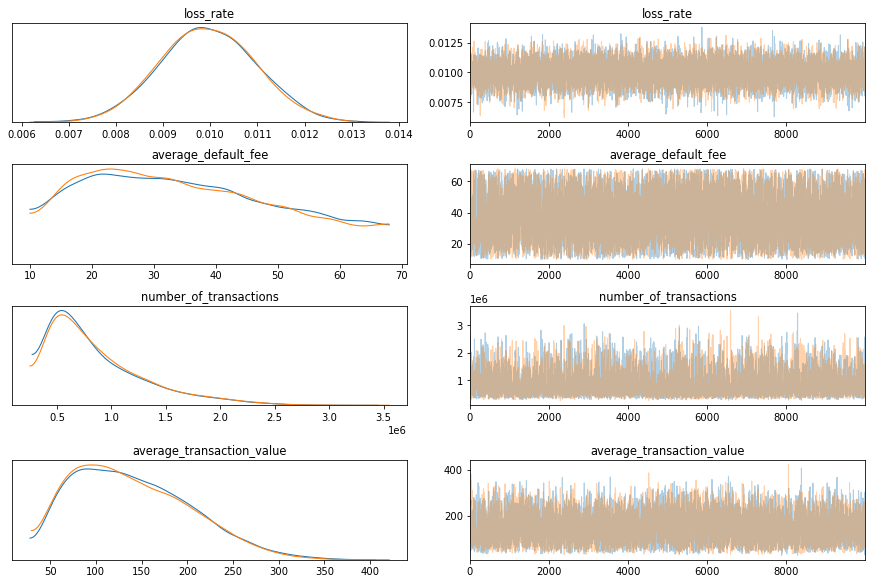

In [32]:
pm.traceplot(trace);

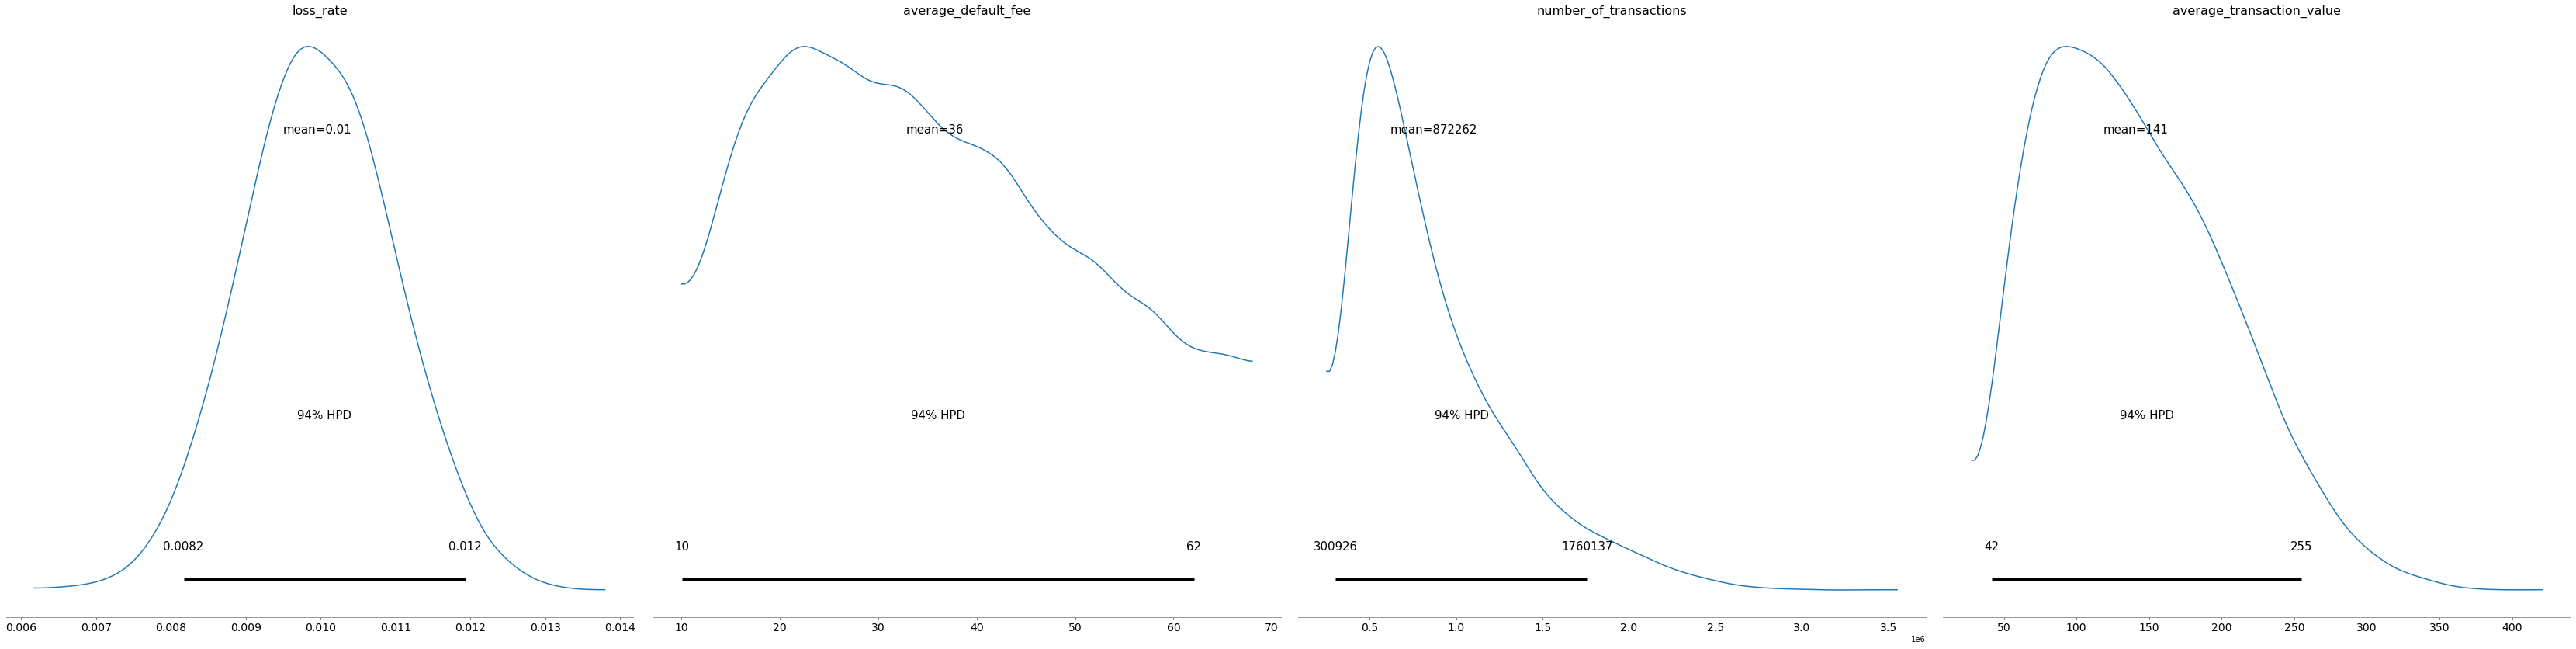

In [33]:
pm.plot_posterior(trace);

In [34]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
loss_rate,0.010,0.001,0.008,0.012,0.000,0.000,7264.0,7264.0,7263.0,7344.0,1.0
average_default_fee,35.699,15.320,10.012,62.076,0.232,0.164,4345.0,4345.0,4213.0,6038.0,1.0
number_of_transactions,872262.401,451793.009,300926.348,1760136.553,7010.986,4957.864,4153.0,4153.0,4183.0,5987.0,1.0
average_transaction_value,140.647,62.953,41.637,255.076,0.949,0.671,4398.0,4398.0,4258.0,6067.0,1.0


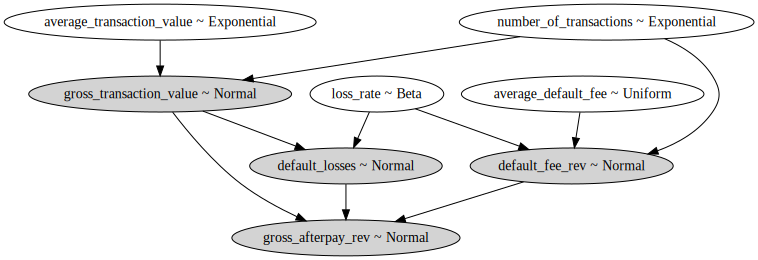

In [35]:
pm.model_to_graphviz(model)